## Parte 2 - Lidando com Dados Tratados

In [175]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter as gf
import datetime

### Identificando os modos POD e plotando 
Aqui, partiremos dos dados temporais de indíce pluviométrico tratados na parte 1. Os dados, embora localizados espacialmente, serão associados a uma cidade para melhor visualização dos modos. Em seguida, iremos utilizar de interpolação para estimar informação sobre as cidades que não incluem uma estação em seu território.  

As saídas do código abaixo serão
- mapa de modos POD
- influência de cada modo ao longo do tempo

In [59]:
Ind_Pluv = pd.read_csv('./Salvos/Indice_Pluviometrico_x_Tempo.csv', sep=',')
Loc = gpd.read_file('./Salvos/Infos_x_Localizacao.csv', 
                    GEOM_POSSIBLE_NAMES="geometry", 
                    KEEP_GEOM_COLUMNS="NO")

### Proper Ortoghonal Decomposition

In [227]:
n_modos = 10
Chuva = np.zeros(( int(Ind_Pluv.shape[0]/24), int(Ind_Pluv.shape[1])  ))

aux = np.array(Ind_Pluv)

for i,r in enumerate(np.arange(0,len(Ind_Pluv),24)):
    Chuva[i,:] = aux[r:r+24,:].sum(axis=0) 


m = len(Chuva)
Chuva_desvio = Chuva - Chuva.mean(axis=0)

#Metodo mais simples
Cov = (1/(m-1))*np.dot( Chuva_desvio.T, Chuva_desvio)
Lambda, Phi = np.linalg.eig(Cov)

k = np.argsort(Lambda)[::-1] #Ordenando autovalores do maior para o menor 
Lambda = Lambda[k]
Phi = Phi[:,k]

A = np.dot(Chuva_desvio, Phi )

#As colunas de Phi sao os Modos POD
Modos = gpd.GeoDataFrame()
Modos['Código'] = Ind_Pluv.columns
for k in np.arange(n_modos):
    Modos[f'Modo_{k+1}'] = np.real(Phi[:,k])

##### Plot dos Resultados 

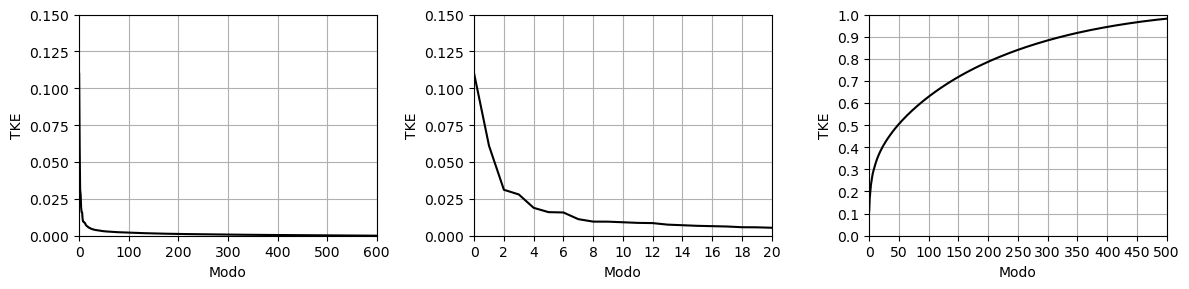

In [228]:
plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
plt.plot(Lambda/Lambda.sum(),'k')
plt.xticks(np.arange(0,901,100))
plt.xlim(0,600)

plt.yticks(np.arange(0,0.151,0.025))
plt.ylim(0,0.15)

plt.xlabel('Modo')
plt.ylabel('TKE')

plt.grid()
plt.tight_layout()

plt.subplot(1,3,2)
plt.plot(Lambda/Lambda.sum(),'k')
plt.xticks(np.arange(0,91,2))
plt.xlim(0,20)

plt.yticks(np.arange(0,0.151,0.025))
plt.ylim(0,0.15)

plt.xlabel('Modo')
plt.ylabel('TKE')

plt.grid()
plt.tight_layout()

plt.subplot(1,3,3)
plt.plot(np.cumsum(Lambda)/Lambda.sum(),'k')
plt.xticks(np.arange(0,501,50))
plt.xlim(0,500)

plt.yticks(np.arange(0,1.1,0.1))
plt.ylim(0,1)

plt.xlabel('Modo')
plt.ylabel('TKE')

plt.grid()
plt.tight_layout()

### Associando cada Estação à sua respectiva Cidade
Cerca de 9% dos munícipios do páis possuem estação do Inmet. Para facilitar nossa visualização, vamos estender os dados registrados paras estações aos municípios que as contém. Mas onde conseguir os mapas dos municípios? No site do IBGE há dados sobre os limites dos municípios no formato shapefile (shp), adequado para a construção de mapas. 

In [68]:
#Abrindo limites municipais
Cidades = gpd.read_file('./2022/BR_Municipios_2022/BR_Municipios_2022.shp')
Cidades["centroid"] = Cidades["geometry"].centroid


#Abrindo limites estaduais
UF = gpd.read_file('./2022/BR_UF_2022/BR_UF_2022.shp')

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_6160/1323636346.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Cidades["centroid"] = Cidades["geometry"].centroid


#### Cruzando Código Com Município

In [75]:
for k in np.arange(n_modos):
    Cidades[f'Modo_{k+1}'] = np.NAN

for indice in range(Cidades.shape[0]-1):

    pip = Loc.within(Cidades.loc[indice, 'geometry'])
    
    if pip.sum() > 0: 
        i = Loc.loc[pip, 'Código']
        for k in np.arange(len(Modos.columns) - 1):
            try:
                Cidades.loc[indice, f'Modo_{k+1}'] = Modos.loc[ (Modos['Código'] == i.values[0]) ][f'Modo_{k+1}'].values[0]
            except:
                Cidades.loc[indice, f'Modo_{k+1}'] = np.NAN
Cidades

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,centroid,Modo_1,Modo_2,Modo_3,Modo_4,Modo_5,Modo_6,Modo_7,Modo_8,Modo_9,Modo_10
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...",POINT (-62.27466 -12.47013),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...",POINT (-62.95726 -9.95189),-0.050882,-0.023027,0.031535,0.010211,0.016802,-0.006627,-0.037153,-0.006284,0.068247,0.004396
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.52408 -13.32137, -60.37162 -13.3...",POINT (-60.63981 -13.47488),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.35502 -11.50452, -61.35524 -11.5...",POINT (-61.32473 -11.30129),-0.048099,-0.019263,0.017735,-0.020244,0.017861,0.022657,-0.064629,-0.014809,0.114141,0.019188
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-60.82135 -13.11910, -60.81773 -13.1...",POINT (-61.26095 -13.20356),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,5222005,Vianópolis,GO,954.115,"POLYGON ((-48.31126 -16.84221, -48.31170 -16.8...",POINT (-48.44077 -16.81281),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5568,5222054,Vicentinópolis,GO,733.794,"POLYGON ((-49.73613 -17.74427, -49.73624 -17.7...",POINT (-49.87269 -17.72364),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5569,5222203,Vila Boa,GO,1052.593,"POLYGON ((-47.07780 -15.06364, -47.07799 -15.0...",POINT (-47.06237 -14.99312),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5570,5222302,Vila Propício,GO,2181.593,"POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...",POINT (-48.81354 -15.26968),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Plot de um Modo POD
Note os vazios, em cinza claro, indicando a ausência de estações em alguns municípios.
O que significam as cores?
Quando dois municípios apresentam cores inversas, diz-se que tais município possui correlação negativo quanto à variação de chuva: quando um dos municípios apresentam aumento de chuva, o outro apresenta diminuição, e vice-versa. Aqui, azul e vermelha representam cores opostas.  

(-76.24759047174989, -26.590499411250004, -35.7023289475499, 7.222992030550026)

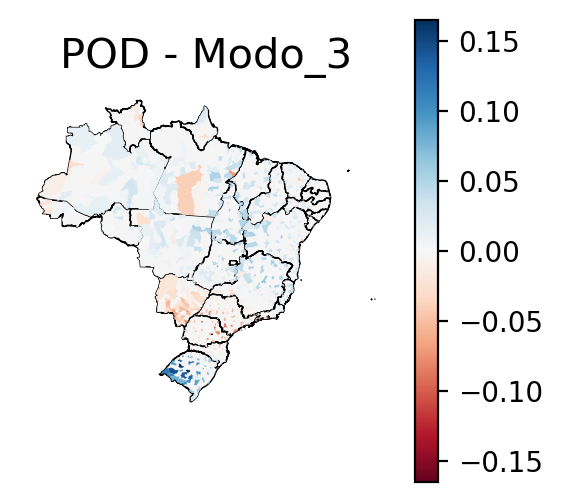

In [90]:
k = 3
%matplotlib inline
fig, ax = plt.subplots(ncols=1, nrows=1 ,figsize=(3,3),dpi=200)

UF.plot(facecolor="whitesmoke", edgecolor="black", ax=ax,lw=0.5)
v = max(np.abs(Cidades[f'Modo_{k}'].min()), np.abs(Cidades[f'Modo_{k}'].max())  )
Cidades.plot(ax=ax,column=f'Modo_{k}',cmap='RdBu',legend=True,vmin=-v,vmax=v)

ax.set_title(f"POD - Modo_{k}", fontsize=15)
ax.axis("off")


### Substituindo dados faltantes por Interpolação entre Cidades 

In [103]:
#Compartilham index
Cidades_nan  = Cidades[pd.isnull(Cidades).any(axis=1)]
Cidades_real = Cidades[~pd.isnull(Cidades).any(axis=1)]

n = 2 # n=2 é o procedimento comum. Qto maior o valor 'n', menor a correlação a longa distnacia. 
for i in np.arange( len(Cidades_nan) ):
    idx   = Cidades_nan.index[i]
    point = Cidades_nan.loc[ idx, 'centroid'  ]

    d_inv = 1.0/( Cidades_real.distance(point)**n )
    for k in np.arange( len(Modos.columns) - 1 ):
        Cidades_nan.loc[idx, f'Modo_{k+1}'] = (d_inv*Cidades_real[f'Modo_{k+1}']).sum()/d_inv.sum()

Cidades_Full = pd.concat([Cidades_nan, Cidades_real ])

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_6160/1096404523.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  d_inv = 1.0/( Cidades_real.distance(point)**n )
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_6160/1096404523.py:13: RuntimeWarning: invalid value encountered in scalar divide
  Cidades_nan.loc[idx, f'Modo_{k+1}'] = (d_inv*Cidades_real[f'Modo_{k+1}']).sum()/d_inv.sum()


#### Visualizando um MODO

(-76.24759047174989, -26.590499411250004, -35.7023289475499, 7.222992030550026)

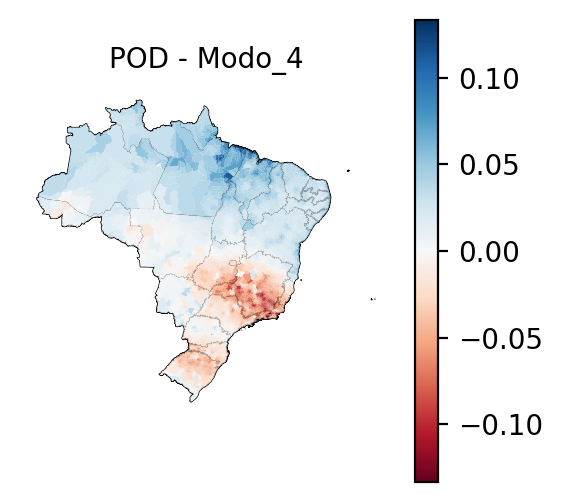

In [229]:

k = 4
%matplotlib inline
fig, ax = plt.subplots(ncols=1, nrows=1 ,figsize=(3,3),dpi=200)

UF.plot(facecolor="whitesmoke", edgecolor="black", ax=ax,lw=0.5)
v = max(np.abs(Cidades_Full[f'Modo_{k}'].min()), np.abs(Cidades_Full[f'Modo_{k}'].max())  )
Cidades_Full.plot(ax=ax,column=f'Modo_{k}',cmap='RdBu',legend=True,vmin=-v,vmax=v)

ax.set_title(f"POD - Modo_{k}", fontsize=10)
ax.axis("off")


## Resultados

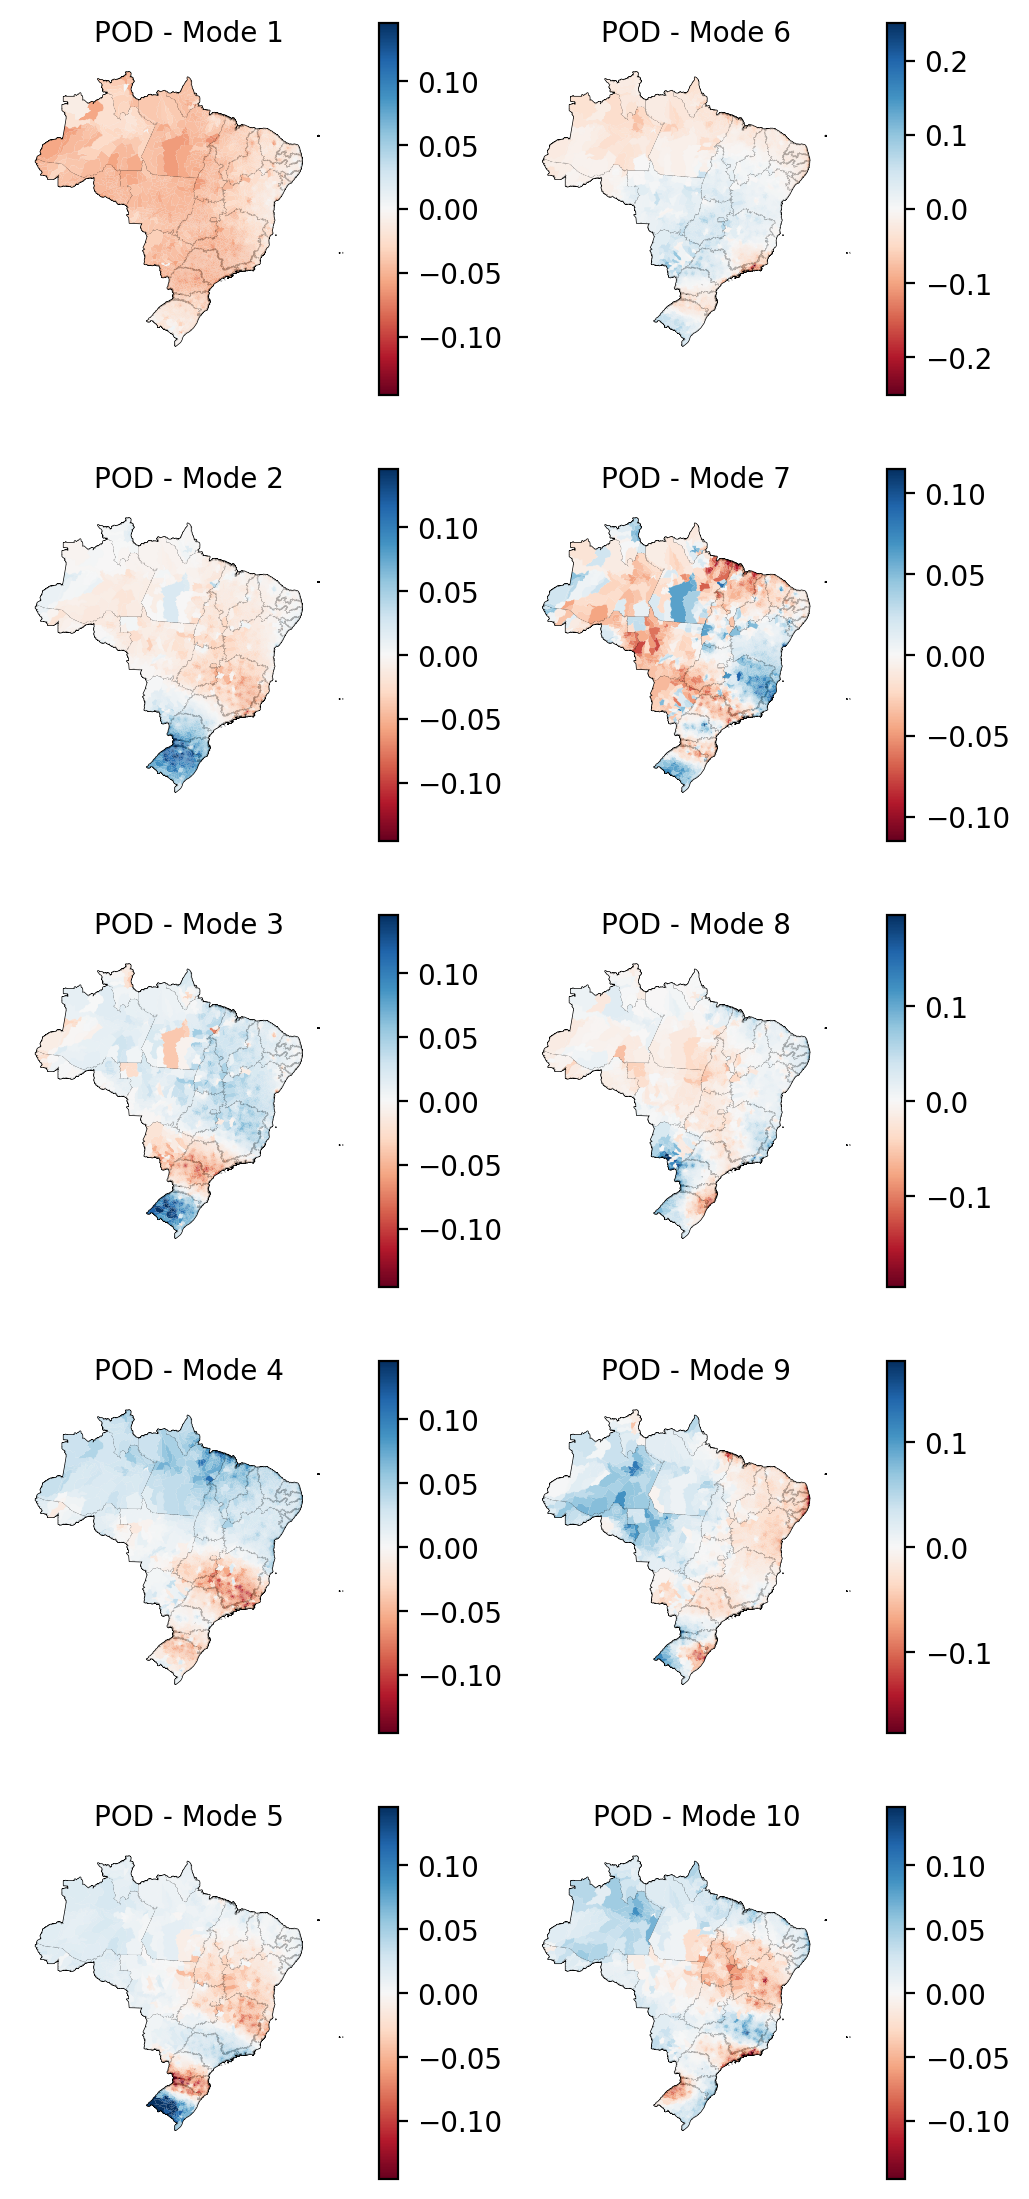

In [107]:
%matplotlib inline
fig, ax = plt.subplots(ncols=2, nrows=5 ,figsize=(6, 14),dpi=200)

for k in np.arange(5):          
    UF.plot(facecolor="whitesmoke", edgecolor="black", ax=ax[k,0],lw=0.5)
    Cidades_Full.plot(ax=ax[k,0],column=f"Modo_{k+1}",cmap='RdBu',legend=True,vmin=-v,vmax=v)
    ax[k,0].set_title(f"POD - Mode {k+1}", fontsize=10)
    ax[k,0].axis("off")

for k in np.arange(5,10):          
    UF.plot(facecolor="whitesmoke", edgecolor="black", ax=ax[k-5,1],lw=0.5)
    v = max(np.abs(Cidades_Full[f'Modo_{k+1}'].min()), np.abs(Cidades_Full[f'Modo_{k+1}'].max())  )
    Cidades_Full.plot(ax=ax[k-5,1],column=f"Modo_{k+1}",cmap='RdBu',legend=True,vmin=-v,vmax=v)
    ax[k-5,1].set_title(f"POD - Mode {k+1}", fontsize=10    )
    ax[k-5,1].axis("off")

plt.savefig('Modos.png')

### Identificando os Coeficientes
O método POD é capaz de reduzir a distribuição espaço-temporal de chuvas na combinação linear de modos, ou melhor:
$$ Ind_{Pluv}(diário) = A\times PHI^{T}, $$ 
em que $PHI$ são os modos espaciais indentificados para a distribuição de chuvas e $A$ a importância dos respecitivos modos, na forma de um coeficiente, ao longo do tempo, definido por:
\begin{bmatrix}
    a_1(0)  & ... & a_n(0)  \\
    \vdots  & \ddots & \vdots  \\
    a_1(m)  & ... & a_n(m)  
\end{bmatrix}
em que $n$ é o número total de modos e $m$, de observações temporais.  

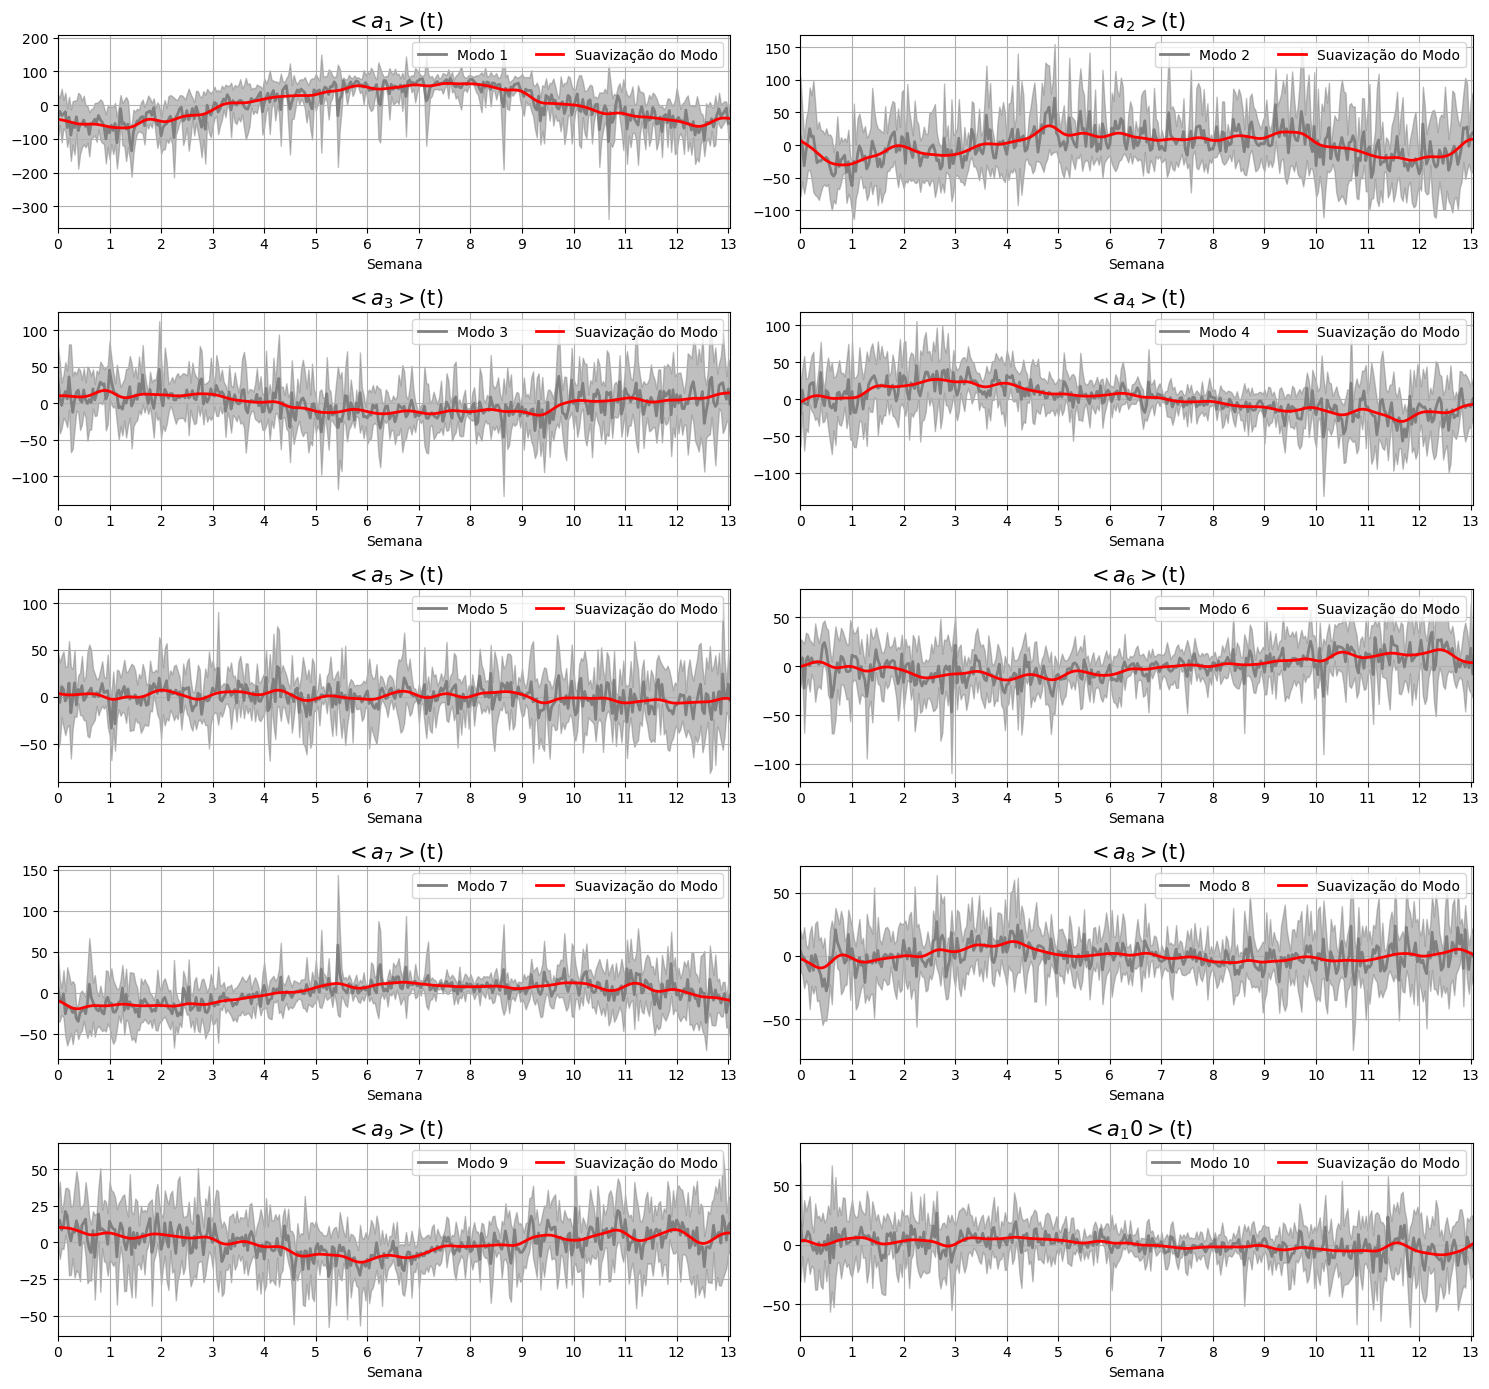

In [267]:
%matplotlib inline
plt.figure(figsize=(15, 14))
x = pd.date_range(start='1-1-2013', end='31-12-2020',periods=A.shape[0])

for k in np.arange(10):  
    plt.subplot(5,2,k+1)
    plt.xlabel('Semana')
    plt.xlim(0,365)
    plt.title(f'$<a_{(k+1)}>$(t)',fontsize=15)
    
    plt.xticks(np.arange(0,365,28),np.arange(0,14,1))
 
    a = A[:,k].reshape(8,369).mean(axis=0)
    da = A[:,k].reshape(8,369).std(axis=0)

    a2 = gf(A[:,k],5).reshape(8,369).mean(axis=0)
    
    plt.plot(a,'-',color='gray',ms=0.1,lw=2,label=f'Modo {k+1}',markevery=1) 
    plt.fill_between(np.arange(len(a)),a-da,a+da,color='gray',alpha=0.5)
    
    
    plt.plot(a2,'r-',ms=0.1,lw=2,label=f'Suavização do Modo',markevery=1) 

    plt.legend(ncol=2)
    plt.grid()

plt.tight_layout()
plt.savefig('Coeficientes.png',dpi=200)

### Resultados Por Estado

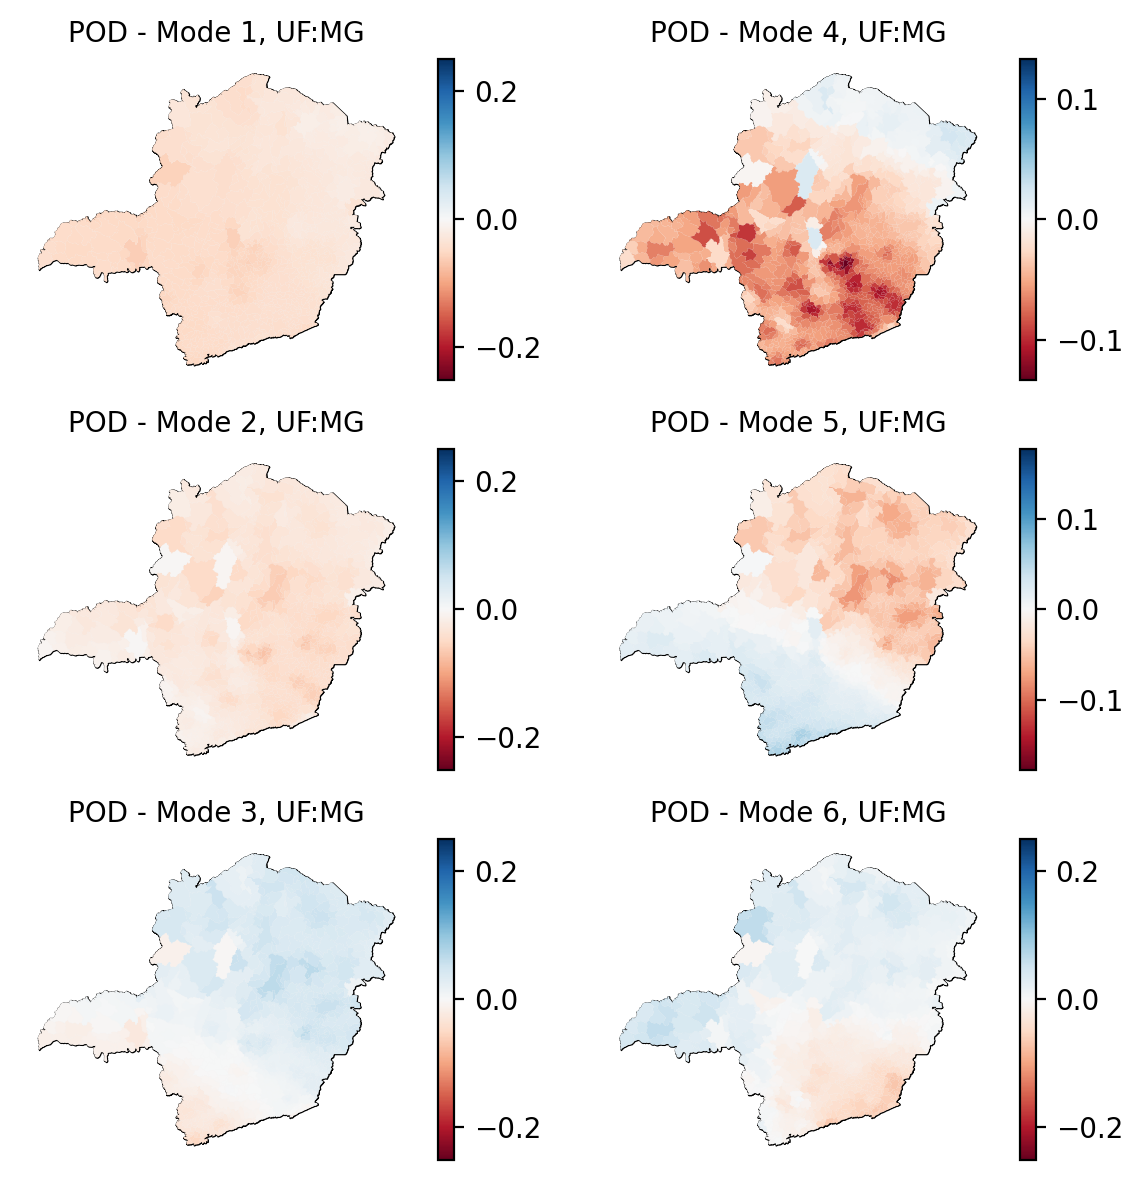

In [222]:
uf = 'MG'
%matplotlib inline
fig, ax = plt.subplots(ncols=2, nrows=3 ,figsize=(6, 6),dpi=200)

for k in np.arange(3):          
    UF.loc[(UF['SIGLA_UF']==uf)].plot(facecolor="whitesmoke", edgecolor="black", ax=ax[k,0],lw=0.5)
    Cidades_Full.loc[(Cidades_Full['SIGLA_UF']==uf)].plot(ax=ax[k,0],column=f"Modo_{k+1}",cmap='RdBu',legend=True,vmin=-v,vmax=v)
    ax[k,0].set_title(f"POD - Mode {k+1}, UF:{uf}", fontsize=10)
    ax[k,0].axis("off")

for k in np.arange(3,6):          
    UF.loc[(UF['SIGLA_UF']==uf)].plot(facecolor="whitesmoke", edgecolor="black", ax=ax[k-3,1],lw=0.5)
    v = max(np.abs(Cidades_Full[f'Modo_{k+1}'].min()), np.abs(Cidades_Full[f'Modo_{k+1}'].max())  )
    Cidades_Full.loc[(Cidades_Full['SIGLA_UF']==uf)].plot(ax=ax[k-3,1],column=f"Modo_{k+1}",cmap='RdBu',legend=True,vmin=-v,vmax=v)
    ax[k-3,1].set_title(f"POD - Mode {k+1}, UF:{uf}", fontsize=10)
    ax[k-3,1].axis("off")

plt.tight_layout()
plt.savefig('Modos_MG.png')

In [236]:
A2 = np.zeros( A.shape[0]/8 , A.shape[1])

A[:,k].reshape(8,369)

TypeError: expected a sequence of integers or a single integer, got '369.0'

In [240]:
A[:,k].reshape(8,369).mean(axis=0)

(369,)

In [231]:
2952/8

369.0